In [1]:
# pip install pivottablejs

In [2]:
import numpy as np
import pandas as pd

data = r"C:\Users\bolaj\Desktop\Desk\Data\Finance Loan Approval\Finance_Loan_Approval\data\train.csv"
data_1 = r"C:\Users\bolaj\Desktop\Desk\Data\Finance Loan Approval\Finance_Loan_Approval\data\test.csv"
# data=r"C:\Users\bolaj\Desktop\Desk\Data\Finance Loan Approval\Loan_default.csv"

In [3]:
df = pd.read_csv(data)
Test = pd.read_csv(data_1)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pivottablejs import pivot_ui

import warnings
warnings.filterwarnings("ignore")

#import pipeline and transformers
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

#import preprocessors 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.impute import SimpleImputer

from sklearn.metrics import classification_report, confusion_matrix,make_scorer,f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score

import time

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


#import train_test split
from sklearn.model_selection import GridSearchCV,train_test_split

from sklearn.base import BaseEstimator, TransformerMixin

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [6]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [7]:
df.shape

(614, 13)

In [8]:
# Train = Train.dropna(subset=['Credit_History'])
df.sample(frac=0.004)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
468,LP002502,Female,Yes,2,Not Graduate,NaN,210,2917.0,98.0,360.0,1.0,Semiurban,Y
479,LP002533,Male,Yes,2,Graduate,No,2947,1603.0,NaN,360.0,1.0,Urban,N


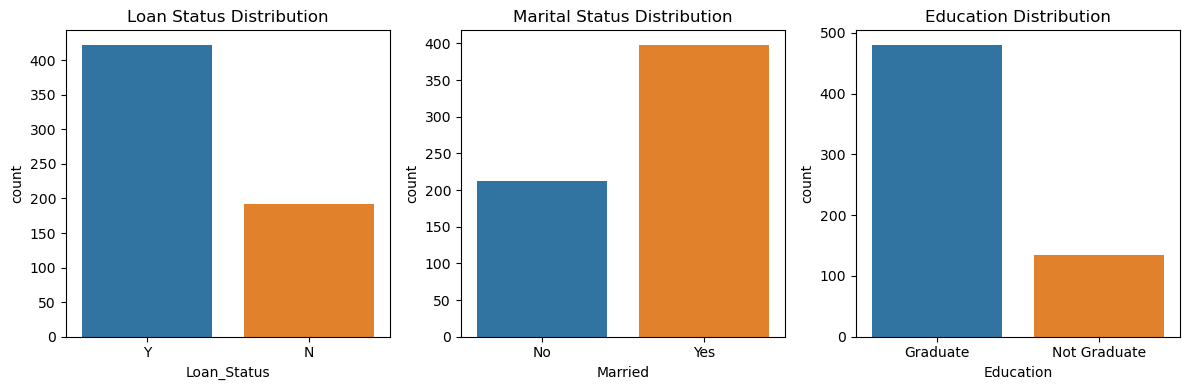

In [9]:
# Plotting distributions
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.countplot(data=df, x='Loan_Status')
plt.title('Loan Status Distribution')

plt.subplot(1, 3, 2)
sns.countplot(data=df, x='Married')
plt.title('Marital Status Distribution')

plt.subplot(1, 3, 3)
sns.countplot(data=df, x='Education')
plt.title('Education Distribution')

plt.tight_layout()
plt.show()

In [10]:
df['Credit_History'] = df['Credit_History'].astype('category')

In [11]:
print(df.shape, "\n") 
print(df.columns, "\n") 

(614, 13) 

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object') 



In [12]:
df = df.drop('Loan_ID',axis=1)

In [13]:
pivot_ui(df)

In [14]:
df['Loan_Amount_Term'].nunique()

10

In [15]:
df['Loan_Status'] = df['Loan_Status'].replace({'Y': 1, 'N': 0})
# df.rename(columns={'Default': 'Loan_Status'}, inplace=True)

In [16]:
X ,y = df.drop(['Loan_Status'],axis=1),df['Loan_Status']

In [17]:
# import sklearn
# print(sklearn.__version__)

In [18]:
# Set a random seed for reproducibility
random_seed = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y,test_size=0.4, train_size=0.6, random_state=random_seed)

In [19]:
X_train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
332,Male,No,NaN,Graduate,No,2833,0.0,71.0,360.0,1.0,Urban
320,Male,Yes,0,Graduate,No,2400,2167.0,115.0,360.0,1.0,Semiurban
49,Female,No,0,Graduate,No,4000,2275.0,144.0,360.0,1.0,Semiurban
274,Male,Yes,2,Graduate,No,3900,0.0,90.0,360.0,1.0,Semiurban
25,Male,Yes,0,Graduate,Yes,9560,0.0,191.0,360.0,1.0,Semiurban


In [20]:
categorical_features = X_train.select_dtypes(exclude=['float64','int64']).columns.tolist()

In [21]:
categorical_features

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Credit_History',
 'Property_Area']

In [22]:
#numerical features excluding booleans and object to list 
numeric_features = X_train.select_dtypes(exclude=['bool', 'object','category']).columns.tolist()

In [23]:
numeric_features

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

In [24]:
categorical_imputer = SimpleImputer(strategy='most_frequent')
numerical_imputer = SimpleImputer(strategy='median')

In [25]:
#setting up a pipeline for scaling the numerical features
numeric_transformer = Pipeline(
    steps=[ 
        ('imputer', numerical_imputer),
        ("scaler", StandardScaler())
    ]
).set_output(transform='pandas')
numeric_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [26]:
# Define preprocessing steps for categorical and numerical data
categorical_pipeline = Pipeline([
    ('imputer', categorical_imputer),
    ('encoder', OneHotEncoder(sparse_output=False,
        handle_unknown='infrequent_if_exist',min_frequency =0.01))
])
categorical_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder',
                 OneHotEncoder(handle_unknown='infrequent_if_exist',
                               min_frequency=0.01, sparse_output=False))])

In [27]:
# Define column transformer to apply different preprocessing steps to different columns
Fill_na = ColumnTransformer([
    ('categorical', categorical_pipeline, categorical_features),
    # ('numerical', numeric_transformer, numeric_features)
])

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('Fill_na',Fill_na, categorical_features),
        ("num", numeric_transformer, numeric_features)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)
preprocessor.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('Fill_na',
                                 ColumnTransformer(transformers=[('categorical',
                                                                  Pipeline(steps=[('imputer',
                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                  ('encoder',
                                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                 min_frequency=0.01,
                                                                                                 sparse_output=False))]),
                                                                  ['Gender',
                                                                   'Married',
                                                                   'Dependents',
                                                                   'Education',
                                                                   'Self_Employed',
                                                                   'Credit_History',
                                                                   'Property_Area'])]),
                                 ['Gender', 'Married', 'Dependents',
                                  'Education', 'Self_Employed',
                                  'Credit_History', 'Property_Area']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['ApplicantIncome', 'CoapplicantIncome',
                                  'LoanAmount', 'Loan_Amount_Term'])],
                  verbose_feature_names_out=False)

In [29]:
categorical_features

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Credit_History',
 'Property_Area']

In [30]:
X_train.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

In [31]:
X_train = preprocessor.fit_transform(X_train,y_train)

In [32]:
X_test=preprocessor.transform(X_test)

In [33]:
X_train.head()

,categorical__Gender_Female,categorical__Gender_Male,categorical__Married_No,categorical__Married_Yes,categorical__Dependents_0,categorical__Dependents_1,categorical__Dependents_2,categorical__Dependents_3+,categorical__Education_Graduate,categorical__Education_Not Graduate,...,categorical__Self_Employed_Yes,categorical__Credit_History_0.0,categorical__Credit_History_1.0,categorical__Property_Area_Rural,categorical__Property_Area_Semiurban,categorical__Property_Area_Urban,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
332,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,-0.436483,-0.587374,-0.867206,0.296646
320,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,-0.508138,0.233664,-0.357152,0.296646
49,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,-0.243360,0.274583,-0.020979,0.296646
274,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,-0.259909,-0.587374,-0.646956,0.296646
25,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.676745,-0.587374,0.523852,0.296646


In [34]:
# X_train[['numerical__LoanAmount','LoanAmount']]
X_train.columns

Index(['categorical__Gender_Female', 'categorical__Gender_Male',
       'categorical__Married_No', 'categorical__Married_Yes',
       'categorical__Dependents_0', 'categorical__Dependents_1',
       'categorical__Dependents_2', 'categorical__Dependents_3+',
       'categorical__Education_Graduate',
       'categorical__Education_Not Graduate', 'categorical__Self_Employed_No',
       'categorical__Self_Employed_Yes', 'categorical__Credit_History_0.0',
       'categorical__Credit_History_1.0', 'categorical__Property_Area_Rural',
       'categorical__Property_Area_Semiurban',
       'categorical__Property_Area_Urban', 'ApplicantIncome',
       'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'],
      dtype='object')

In [35]:
# X_train.drop(['numerical__LoanAmount','numerical__Loan_Amount_Term'],axis=1,inplace=True)

In [36]:
X_test.columns

Index(['categorical__Gender_Female', 'categorical__Gender_Male',
       'categorical__Married_No', 'categorical__Married_Yes',
       'categorical__Dependents_0', 'categorical__Dependents_1',
       'categorical__Dependents_2', 'categorical__Dependents_3+',
       'categorical__Education_Graduate',
       'categorical__Education_Not Graduate', 'categorical__Self_Employed_No',
       'categorical__Self_Employed_Yes', 'categorical__Credit_History_0.0',
       'categorical__Credit_History_1.0', 'categorical__Property_Area_Rural',
       'categorical__Property_Area_Semiurban',
       'categorical__Property_Area_Urban', 'ApplicantIncome',
       'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'],
      dtype='object')

In [37]:
# X_test.drop(['numerical__LoanAmount','numerical__Loan_Amount_Term'],axis=1,inplace=True)

In [38]:
Gbrpipeline = Pipeline(
    steps=[
        ("gbr", GradientBoostingClassifier()
        )
    ]
).set_output(transform='pandas')
Gbrpipeline

Pipeline(steps=[('gbr', GradientBoostingClassifier())])

In [39]:
Gbrpipeline.fit(X_train, y_train)

Pipeline(steps=[('gbr', GradientBoostingClassifier())])

In [40]:
Gbrpipeline.score(X_train, y_train), Gbrpipeline.score(X_test,y_test)

(0.9130434782608695, 0.7764227642276422)

In [41]:
# Predict the target values for the test data
y_pred_Gbr = Gbrpipeline.predict(X_test)
y_pred_Gbr

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1], dtype=int64)

In [42]:
# Generate classification report
report = classification_report(y_test, y_pred_Gbr)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.41      0.56        85
           1       0.76      0.97      0.85       161

    accuracy                           0.78       246
   macro avg       0.82      0.69      0.71       246
weighted avg       0.80      0.78      0.75       246



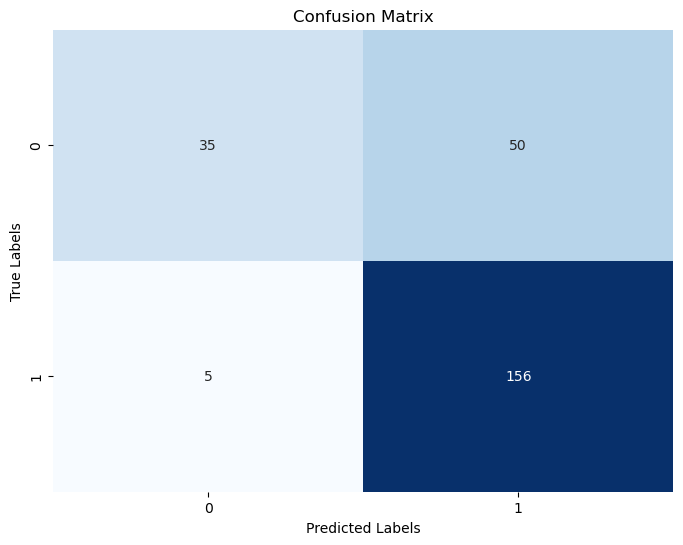

In [43]:
conf_matrix = confusion_matrix(y_test, y_pred_Gbr)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### Random Forest

In [44]:
Rdpipeline = Pipeline(
    steps=[
        ("rf", RandomForestClassifier()
        )
    ]
).set_output(transform='pandas')
Rdpipeline

Pipeline(steps=[('rf', RandomForestClassifier())])

In [45]:
Rdpipeline.fit(X_train, y_train)

Pipeline(steps=[('rf', RandomForestClassifier())])

In [46]:
X_train.columns

Index(['categorical__Gender_Female', 'categorical__Gender_Male',
       'categorical__Married_No', 'categorical__Married_Yes',
       'categorical__Dependents_0', 'categorical__Dependents_1',
       'categorical__Dependents_2', 'categorical__Dependents_3+',
       'categorical__Education_Graduate',
       'categorical__Education_Not Graduate', 'categorical__Self_Employed_No',
       'categorical__Self_Employed_Yes', 'categorical__Credit_History_0.0',
       'categorical__Credit_History_1.0', 'categorical__Property_Area_Rural',
       'categorical__Property_Area_Semiurban',
       'categorical__Property_Area_Urban', 'ApplicantIncome',
       'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'],
      dtype='object')

In [47]:
Rdpipeline.score(X_train, y_train), Rdpipeline.score(X_test,y_test)

(1.0, 0.7845528455284553)

In [48]:
# Predict the target values for the test data
y_pred_Rdn = Rdpipeline.predict(X_test)
y_pred_Rdn

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1], dtype=int64)

In [49]:
# Generate classification report
report_rd = classification_report(y_test, y_pred_Rdn)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.41      0.56        85
           1       0.76      0.97      0.85       161

    accuracy                           0.78       246
   macro avg       0.82      0.69      0.71       246
weighted avg       0.80      0.78      0.75       246



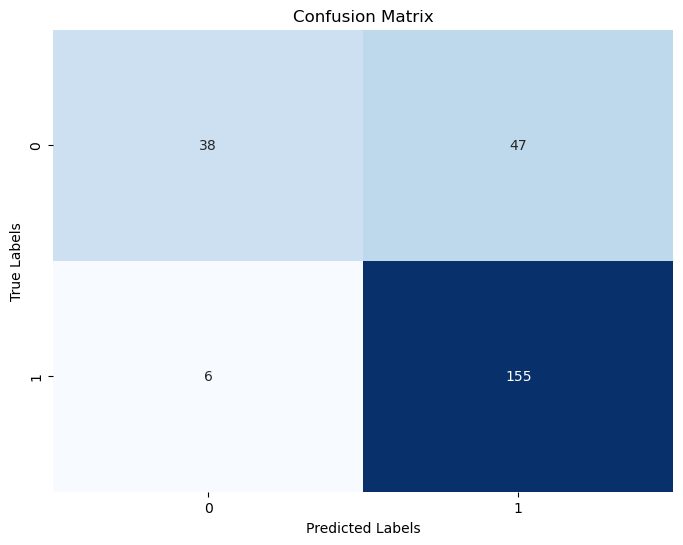

In [50]:
conf_matrix_rd= confusion_matrix(y_test, y_pred_Rdn)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rd, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### Grid Search

In [51]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [20, 35, 50],
    'learning_rate': [0.01, 0.1], 
    'max_depth': [3,5,10], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

In [52]:
# # Initialize the gradient boosting classifier
gb_clf = GradientBoostingClassifier()

In [53]:
# Define the scorer using F1-score
scorer = make_scorer(f1_score, pos_label=1) 

In [54]:
# Initialize GridSearchCV with the defined parameter grid and the classifier
grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=10, scoring=scorer, verbose=1)

In [55]:
# Perform grid search on the training data
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 486 candidates, totalling 4860 fits


GridSearchCV(cv=10, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [20, 35, 50],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring=make_scorer(f1_score, response_method='predict', pos_label=1),
             verbose=1)

In [56]:
# Get the best estimator
best_gb_clf = grid_search.best_estimator_

In [57]:
best_gb_clf

GradientBoostingClassifier(min_samples_leaf=2, min_samples_split=5,
                           n_estimators=20)

In [58]:
# best_gb_clf = GradientBoostingClassifier(learning_rate=0.1, 
#                                          max_depth=3, 
#                                          min_samples_leaf=1, 
#                                          min_samples_split=2, 
#                                          n_estimators=50, 
#                                          subsample=0.8)

In [59]:
best_gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(min_samples_leaf=2, min_samples_split=5,
                           n_estimators=20)

In [60]:
# Get the best estimator
# best_gb_clf = grid_search.best_estimator_

In [61]:
gb_pred = best_gb_clf.predict(X_test)

In [62]:
# Generate classification report
report = classification_report(y_test, gb_pred)

# Print the classification report
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.31      0.46        85
           1       0.73      0.99      0.84       161

    accuracy                           0.75       246
   macro avg       0.83      0.65      0.65       246
weighted avg       0.80      0.75      0.71       246



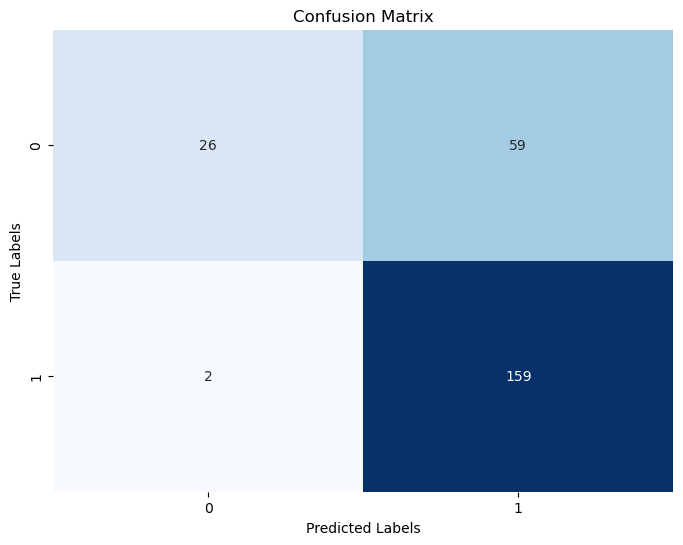

In [63]:
grid_conf_matrix = confusion_matrix(y_test, gb_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(grid_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [64]:
# Specify the columns to drop and column to dropna
columns_to_drop = ['Loan_ID']
column_to_dropna = 'Credit_History'
# columns_to_drop2= ['numerical__LoanAmount','numerical__Loan_Amount_Term']

In [65]:
# Custom transformer to drop specified columns
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Filter out columns that exist in the DataFrame
        existing_columns = [col for col in self.columns if col in X.columns]
        return X.drop(existing_columns, axis=1)

In [66]:
# Custom transformer to drop NA values specifically in the "Credit_History" column
class DropNAForColumn(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[~X[self.column].isnull()]

In [67]:
# Create a Pipeline for dropping columns or rows with missing values
dropper = Pipeline(steps=[
    ('drop_columns', ColumnDropper(columns_to_drop)),  
    ('dropna_credit_history', DropNAForColumn(column='Credit_History'))
])


In [68]:
# Creating the Logistic Regression model with increased max_iter
Saved_model = Pipeline(steps=[
    ('dropper', dropper),
    ('preprocessor', preprocessor),
    # ('drop_columns', ColumnDropper(columns_to_drop2)),
    ('classifier', best_gb_clf)
])
Saved_model

Pipeline(steps=[('dropper',
                 Pipeline(steps=[('drop_columns',
                                  ColumnDropper(columns=['Loan_ID'])),
                                 ('dropna_credit_history',
                                  DropNAForColumn(column='Credit_History'))])),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Fill_na',
                                                  ColumnTransformer(transformers=[('categorical',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy='most...
                                                   'Self_Employed',
                                                   'Credit_History',
                                                   'Property_Area']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount',
                                                   'Loan_Amount_Term'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 GradientBoostingClassifier(min_samples_leaf=2,
                                            min_samples_split=5,
                                            n_estimators=20))])

In [69]:
Test.isna().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [70]:
Test_pred = Saved_model.predict(Test)
Test_pred

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [71]:
# Define the input values for prediction as a DataFrame
testB_value = pd.DataFrame({
    'Loan_ID': ['LP001055'],
    'Gender': ['Female'],
    'Married': ['Yes'],
    'Dependents': ['1'],
    'Education': ['Not Graduate'],
    'Self_Employed': ['Yes'],
    'Property_Area': ['Semiurban'],
    'ApplicantIncome': [2226],
    'CoapplicantIncome': [0],
    'LoanAmount': [59],
    'Loan_Amount_Term': [360],
    'Credit_History': [1]
})

# Predict the output
B_pred = Saved_model.predict(testB_value)

print("Predicted Output:", B_pred)

Predicted Output: [1]


In [72]:
import shap
shap.initjs()

In [73]:
column_names = X_test.columns.tolist()
column_names

['categorical__Gender_Female',
 'categorical__Gender_Male',
 'categorical__Married_No',
 'categorical__Married_Yes',
 'categorical__Dependents_0',
 'categorical__Dependents_1',
 'categorical__Dependents_2',
 'categorical__Dependents_3+',
 'categorical__Education_Graduate',
 'categorical__Education_Not Graduate',
 'categorical__Self_Employed_No',
 'categorical__Self_Employed_Yes',
 'categorical__Credit_History_0.0',
 'categorical__Credit_History_1.0',
 'categorical__Property_Area_Rural',
 'categorical__Property_Area_Semiurban',
 'categorical__Property_Area_Urban',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term']

In [74]:
X100 = shap.utils.sample(X_test, 100)
X100

,categorical__Gender_Female,categorical__Gender_Male,categorical__Married_No,categorical__Married_Yes,categorical__Dependents_0,categorical__Dependents_1,categorical__Dependents_2,categorical__Dependents_3+,categorical__Education_Graduate,categorical__Education_Not Graduate,...,categorical__Self_Employed_Yes,categorical__Credit_History_0.0,categorical__Credit_History_1.0,categorical__Property_Area_Rural,categorical__Property_Area_Semiurban,categorical__Property_Area_Urban,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
259,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,-0.089292,-0.587374,-0.206454,0.296646
569,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,-0.381376,0.194639,-0.484665,0.296646
118,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.016123,0.224191,0.338377,0.296646
54,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.997789,-0.587374,1.625106,0.296646
478,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.852857,0.265111,-0.693324,0.296646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,-0.342652,-0.587374,-0.588995,0.296646
362,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,-0.119245,0.296558,-0.183269,0.296646
11,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,-0.491590,0.109769,-0.426705,0.296646
399,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,-0.657076,0.094614,-0.496258,0.296646


In [75]:
sample_size = 100 # Number of samples to select
random_sample = X_test.sample(n=sample_size, random_state=42)

In [76]:
explainer = shap.Explainer(best_gb_clf.predict, X100)
explainer

In [77]:
shap_values = explainer(random_sample)

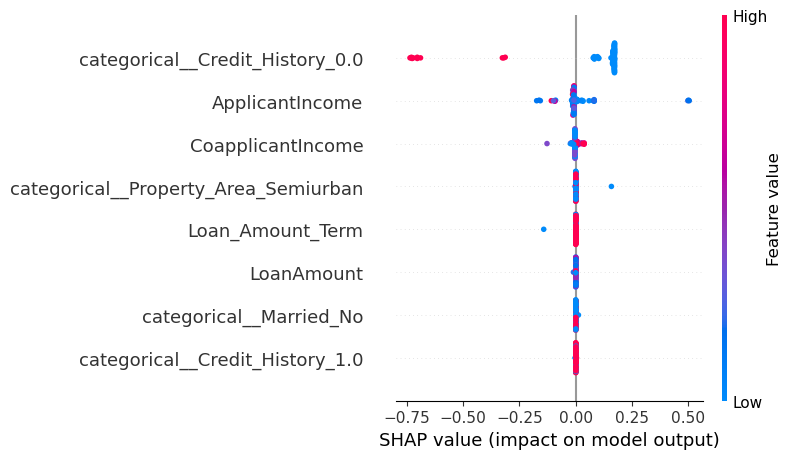

In [78]:
shap.summary_plot(shap_values, random_sample, max_display=8)

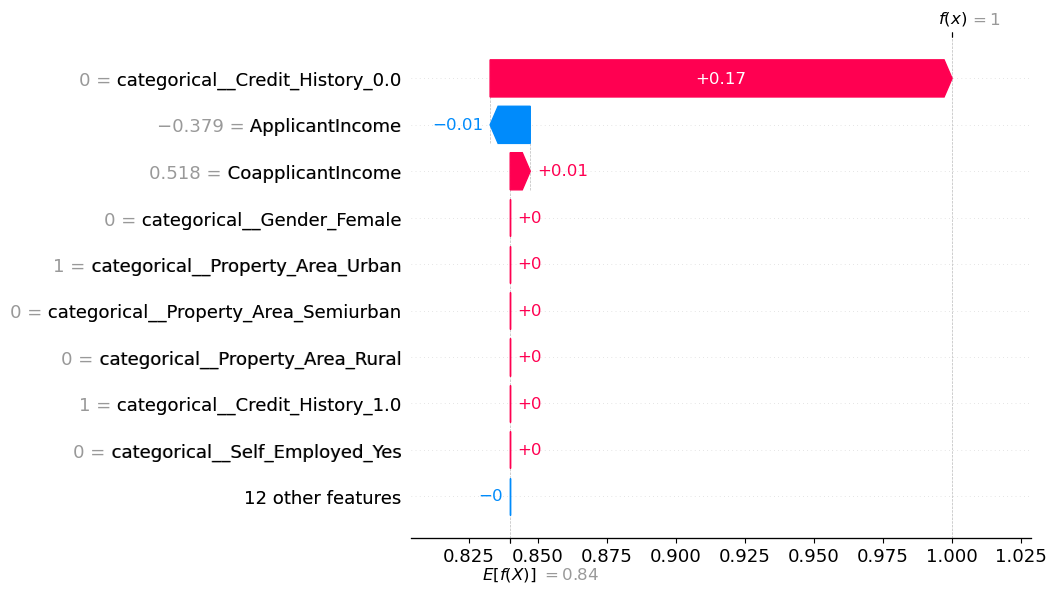

In [79]:
shap.plots.waterfall(shap_values[10])

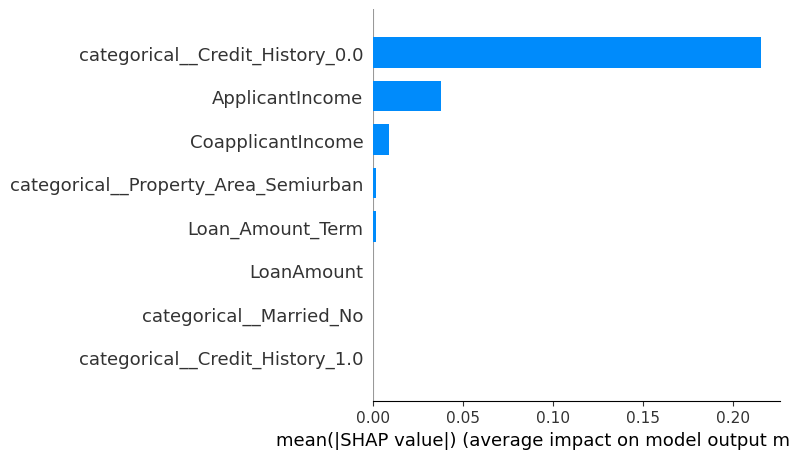

In [80]:
#plot the feature importance
shap.summary_plot(shap_values, random_sample, plot_type="bar",max_display=8)

In [81]:
#set the tree explainer as the model of the pipeline
explainer2 = shap.TreeExplainer(best_gb_clf)

In [82]:
best_gb_clf.predict(random_sample.head(3))

array([1, 1, 1], dtype=int64)

In [83]:
# Create an Explanation object
expected_value = explainer2.expected_value  # Expected value of the model
shap_values2 = shap_values[5]  # Assuming you want to plot for a single instance, adjust as needed

In [84]:
explanation = shap.Explanation(
    values=shap_values2,
    base_values=expected_value,
    data=random_sample,  # Data for the instance you want to explain
    feature_names=column_names
)
explanation

.values =
array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.17045455,  0.00090909,  0.        ,
        0.00045455,  0.        , -0.00909091, -0.00272727,  0.        ,
        0.        ])

.base_values =
0.84

.data =
array([ 0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  5.33667847, -0.58737449,  0.07175795,
        0.2966455 ])

In [85]:
# Use shap.force_plot with the Explanation object
shap.force_plot(
    explanation.base_values,
    explanation.values,
    features=explanation.data,
    feature_names=explanation.feature_names
)

Deploy

In [86]:
# pip install gradio

In [87]:
import pickle
import gradio as gr

In [88]:
# Save the model
with open('Saved_model.pkl', 'wb') as file:
    pickle.dump(Saved_model, file)

In [103]:
def predict_approval(Gender, Married, Dependents, Education, Self_Employed, Property_Area, ApplicantIncome, CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History):
    # Prepare the input features for prediction
    input_features = pd.DataFrame({
        'Gender': [Gender],
        'Married':[Married],
        'Dependents': [Dependents],
        'Education': [Education],
        'Self_Employed': [Self_Employed],
        'Property_Area': [Property_Area],
        'ApplicantIncome': [ApplicantIncome],
        'CoapplicantIncome': [CoapplicantIncome],
        'LoanAmount': [LoanAmount],
        'Loan_Amount_Term': [Loan_Amount_Term],
        'Credit_History': [Credit_History]
    })


    model = pickle.load(open(r"C:\Users\bolaj\Desktop\Desk\Data\Finance Loan Approval\Finance_Loan_Approval\Saved_model.pkl","rb"))

    # Make predictions on the input features
    predicted_approval = model.predict(input_features)

    # Update the output text box with the predicted result
    if predicted_approval[0] == 1:
        output = "Approved"
    else:
        output = "Sorry, we cannot approve your credit now. Please try again later."
    return output

In [104]:
df['Education'].unique()

array(['Graduate', 'Not Graduate'], dtype=object)

In [105]:
df['Dependents'].unique()

array(['0', '1', '2', '3+', nan], dtype=object)

In [106]:
df['Property_Area'].unique()

array(['Urban', 'Rural', 'Semiurban'], dtype=object)

In [107]:
df['Self_Employed'].unique()

array(['No', 'Yes', nan], dtype=object)

In [108]:
predict_approval("M", "Yes", '1', 'Not Graduate', 'Yes', 'Rural',1000,0,1000,360,1)

'Approved'

In [96]:
df['Credit_History'].drop_duplicates().dropna().values.tolist()

[1.0, 0.0]

In [109]:
with gr.Blocks(gr.themes.Soft()) as demo:
    Gender = ['Male', 'Female', 'Others']
    Married = gr.Dropdown(label="Married", choices=df['Married'].drop_duplicates().dropna().values.tolist())
    Dependents = gr.Dropdown(label="Dependents", choices=df['Dependents'].drop_duplicates().dropna().values.tolist())
    Education = gr.Dropdown(label="Education", choices=df['Education'].drop_duplicates().dropna().values.tolist())
    Property_Area = gr.Dropdown(label="Property_Area", choices=df['Property_Area'].drop_duplicates().dropna().values.tolist())

    with gr.Column():
        CoapplicantIncome = gr.Textbox(label="CoapplicantIncome", placeholder="Input CoapplicantIncome...")
        Self_Employed = gr.Radio(["Yes", "No"], label="Self Employed")
        ApplicantIncome = gr.Textbox(label="Applicant Income", placeholder="Input Income...")
        LoanAmount = gr.Textbox(label="Loan Amount", placeholder="Input Loan Amount...")
        Loan_Amount_Term = gr.Textbox(label="Loan Term", placeholder="Input Loan Term...")
        Credit_History = gr.Radio([1.0, 0.0], label="Credit History")
        Gender = gr.Dropdown(Gender, label="Gender")
        generate_btn = gr.Button("Predict Approval")
        gr.Markdown("Predicted Approval:")
        output = gr.Text(label="Predict Approval")

    generate_btn.click(fn=predict_approval, inputs=[Gender, Married, Dependents, Education, Self_Employed, Property_Area, ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, Credit_History],outputs=output)

# if __name__ == "__main__":
demo.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


In [100]:
!git lfs install

Updated Git hooks.
Git LFS initialized.


In [101]:
!git clone https://huggingface.co/spaces/Abolaji/Loan_Approval

Cloning into 'Loan_Approval'...
Traceback (most recent call last):
  File "C:\Users\bolaj\AppData\Roaming\Python\Python310\site-packages\gradio\queueing.py", line 527, in process_events
    response = await route_utils.call_process_api(
  File "C:\Users\bolaj\AppData\Roaming\Python\Python310\site-packages\gradio\route_utils.py", line 261, in call_process_api
    output = await app.get_blocks().process_api(
  File "C:\Users\bolaj\AppData\Roaming\Python\Python310\site-packages\gradio\blocks.py", line 1788, in process_api
    result = await self.call_function(
  File "C:\Users\bolaj\AppData\Roaming\Python\Python310\site-packages\gradio\blocks.py", line 1340, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "C:\Users\bolaj\AppData\Roaming\Python\Python310\site-packages\anyio\to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "C:\Users\bolaj\AppData\Roaming\Python\Python310\site-packages\anyio\_backends\_asyncio.py",

In [102]:
!pip install -U scikit-learn

Defaulting to user installation because normal site-packages is not writeable
